In [1]:
import pandas as pd
import dgl
import torch
from functools import partial
from torch.utils.data import DataLoader
from dgllife.utils import smiles_to_bigraph
from utils.eval_meter import Meter
from utils.featurizers import CanonicalAtomFeaturizer
from utils.featurizers import CanonicalBondFeaturizer
from dgllife.utils import one_hot_encoding
from dgllife.data.csv_dataset import MoleculeCSVDataset
import os
import random
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display
%matplotlib inline
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field='hv')
bond_featurizer = CanonicalBondFeaturizer(bond_data_field='he',self_loop=True)

Using backend: pytorch


In [2]:
def set_random_seed(args):
    seed = args['seed']
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
def chirality(atom):
    try:
        return one_hot_encoding(atom.GetProp('_CIPCode'), ['R', 'S']) + \
               [atom.HasProp('_ChiralityPossible')]
    except:
        return [False, False] + [atom.HasProp('_ChiralityPossible')]
def collate_molgraphs(data):
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
    return smiles, bg, labels, masks
def load_data(data):
    dataset = MoleculeCSVDataset(data,
                                 smiles_to_graph=partial(smiles_to_bigraph, add_self_loop=True),
                                 node_featurizer=atom_featurizer,
                                 edge_featurizer=bond_featurizer,
                                 smiles_column='SMILES',
                                 cache_file_path= './ChemXGNN/Data/Aromaticity/graph.bin',
                                 task_names=None,
                                 load=False,init_mask=True,n_jobs=1
                            )

    return dataset

## Molecule preparation 

In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem
from molvs.normalize import Normalizer, Normalization
from rdkit.Chem.SaltRemover import SaltRemover
from molvs.charge import Reionizer, Uncharger

In [4]:
smi='CCOC1=C(C=C(C=C1)C2CC(=O)NC3=C2C(=O)CCC3)Cl'
mol = Chem.MolFromSmiles(smi)
normalizer = Normalizer()
new1 = normalizer.normalize(mol)
remover = SaltRemover()
new2 = remover(new1)
neutralize1 = Reionizer()
new3 = neutralize1(new2)
neutralize2 = Uncharger()
new4 = neutralize2(new3)
Chem.SanitizeMol(new4)
new_smiles = Chem.MolToSmiles(new4,kekuleSmiles=False)

In [5]:
smi=[new_smiles]
df=pd.DataFrame(smi,columns=['SMILES'])
dataset=load_data(df)

Processing dgl graphs from scratch...


## Load Models 

In [6]:
from utils.attentivefp_predictor import AttentiveFPPredictor
atfp=AttentiveFPPredictor(node_feat_size=78,
                          edge_feat_size=12,
                          num_layers=2,
                          num_timesteps=2,
                          graph_feat_size=200,
                          predictor_hidden_feats=128,
                          n_tasks=1)
fn = '../ChemXGNN/Models/AttentiveFP/aromaticity.pt'
atfp.load_state_dict(torch.load(fn, map_location=torch.device('cpu')))

use CPU


<All keys matched successfully>

In [7]:
from utils.gat_predictor import GATPredictor
gat = GATPredictor(in_feats=78,
                   hidden_feats=[256, 256],
                   num_heads=[4, 4],
                   alphas=[0.9658, 0.9658],
                   residuals=[True, True],
                   predictor_hidden_feats=128,
                   n_tasks=1)
fn = '../ChemXGNN/Models/GAT/aromaticity.pt'
gat.load_state_dict(torch.load(fn, map_location=torch.device('cpu')))

use CPU


<All keys matched successfully>

In [8]:
from utils.gcn_predictor import GCNPredictor
import torch.nn.functional as F
gcn = GCNPredictor(in_feats=78,
                   hidden_feats=[64, 64],
                   activation=[F.relu, F.relu],
                   n_tasks=1,
                   residual=[True,True],
                   batchnorm=[False,False],
                   predictor_hidden_feats=64)
fn = '../ChemXGNN/Models/GCN/aromaticity.pt'
gcn.load_state_dict(torch.load(fn, map_location=torch.device('cpu')))

use CPU


<All keys matched successfully>

In [9]:
from utils.graphsage_predictor import GraphSAGEPredictor
import torch.nn as nn
graphsage = GraphSAGEPredictor(in_feats=78,
                           hidden_feats=[128, 128],
                           activation=[nn.LeakyReLU, nn.LeakyReLU],
                           aggregator_type=['lstm', 'lstm'],
                           predictor_hidden_feats=128,
                           n_tasks=1)
fn = '../ChemXGNN/Models/Graphsage/aromaticity.pt'
graphsage.load_state_dict(torch.load(fn, map_location=torch.device('cpu')))

use CPU


<All keys matched successfully>

## IG 

In [10]:
def draw(model,datasets):
    model.eval()
    smiles, bg, label, masks = dataset[0]
    n_feats = bg.ndata['hv'].requires_grad_()
    pred, node_gradient = model.forward(bg, n_feats, get_node_gradient=True)
    prob_aro = torch.sigmoid(node_gradient).numpy().tolist()
    node_gradient = node_gradient.detach().cpu().numpy().tolist()
    nodes = []
    for pred_aro in node_gradient:
        if pred_aro >= 0:
            nodes.append(int(1))
        else:
            nodes.append(int(0))
    m = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(650,650)
    drawer.SetFontSize(1200)
    op = drawer.drawOptions().addAtomIndices=True
    mol = rdMolDraw2D.PrepareMolForDrawing(m)
    c=nodes
    important_index = []
    for i, value in enumerate(c):
        if value == 1:
            important_index.append(i)
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(206,95,115)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
    atom_cols={}
    for bd in important_index:
        atom_cols[bd] = colors[i%9]
    drawer.DrawMolecule(m,highlightAtoms= important_index,highlightBonds=None,highlightAtomColors=atom_cols,
                        highlightAtomRadii={i: .4 for i in important_index}
                               )
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))

D:\anaconda\envs\rdk\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


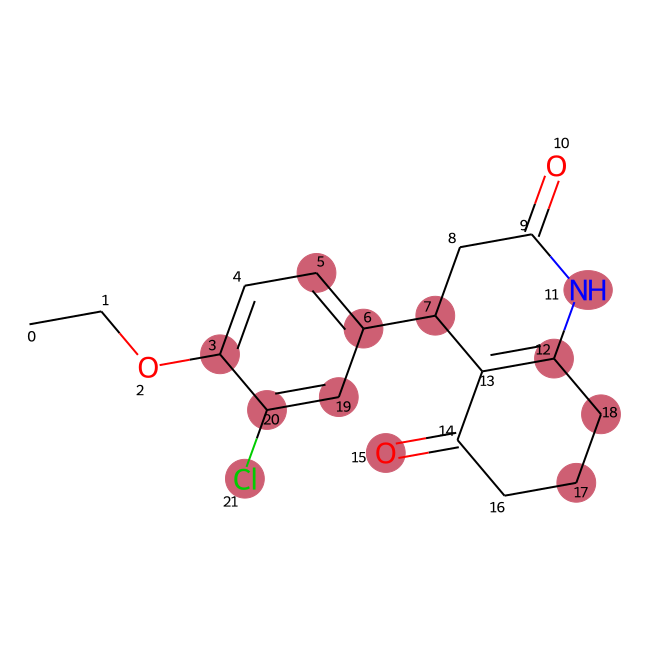

In [11]:
draw(gcn,dataset)

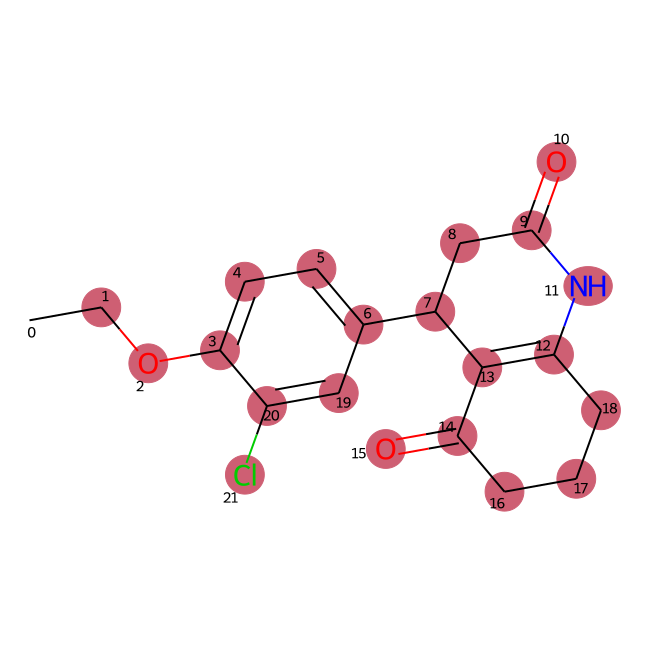

In [12]:
draw(gat,dataset)

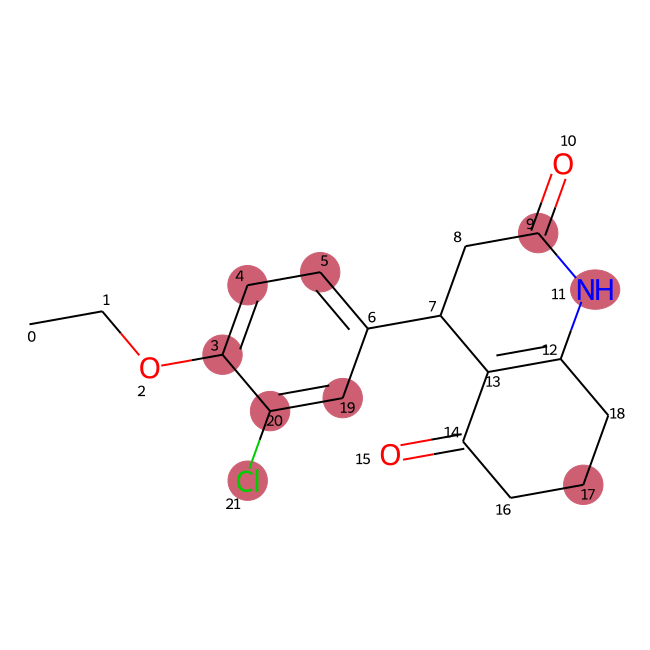

In [13]:
draw(graphsage,dataset)

## AttWeight 

In [14]:
from scipy.sparse import coo_matrix

In [15]:
def draw(model,datasets):
    model.eval()
    smiles, bg, label, masks = dataset[0]
    mol = Chem.MolFromSmiles(smiles)
    adj_arr = Chem.GetAdjacencyMatrix(mol)
    coo_A = coo_matrix(adj_arr)
    row = coo_A.row.tolist()
    n_feats = bg.ndata['hv']
    e_feats = bg.edata['he']
    pred, edge_weight = model.forward(bg, n_feats, get_edge_weight=True)
    edge_weight = edge_weight.reshape(e_feats.shape[0], 4).sum(axis=1).detach().cpu().numpy().tolist()
    node_loop = edge_weight[-n_feats.shape[0]:]
    edge_weight = edge_weight[:-n_feats.shape[0]]
    a = pd.DataFrame(row, columns=['row'])
    c = pd.DataFrame(edge_weight, columns=['e'])
    d = pd.concat([a, c], axis=1)
    data_dict1 = d.groupby('row').e.apply(list).to_dict()
    node_weight0 = []
    for i in range(0, n_feats.shape[0]):
        h = sum(data_dict1[i])
        node_weight0.append(h)
    node_weight = list(map(lambda x: x[0] + x[1], zip(node_weight0, node_loop)))
    min_value = torch.min(torch.tensor(node_weight))
    max_value = torch.max(torch.tensor(node_weight))
    node_weights = (torch.tensor(node_weight) - min_value) / (max_value - min_value)
    node_weight = torch.sigmoid(torch.tensor(node_weight))
    nodes = []
    for pred_aro in node_weights:
        if pred_aro >= sum(node_weights) / len(node_weights):
            nodes.append(1)
        else:
            nodes.append(0)
    m = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(650,650)
    drawer.SetFontSize(1200)
    op = drawer.drawOptions().addAtomIndices=True
    mol = rdMolDraw2D.PrepareMolForDrawing(m)
    c=nodes
    important_index = []
    for i, value in enumerate(c):
        if value == 1:
            important_index.append(i)
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(206,95,115)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
    atom_cols={}
    for bd in important_index:
        atom_cols[bd] = colors[i%9]
    drawer.DrawMolecule(m,highlightAtoms= important_index,highlightBonds=None,highlightAtomColors=atom_cols,
                        highlightAtomRadii={i: .4 for i in important_index}
                               )
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))

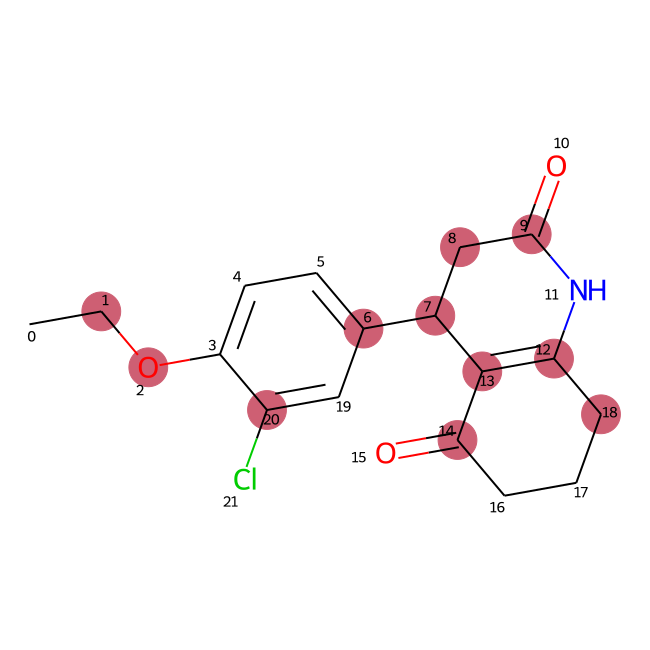

In [16]:
draw(gat,dataset)

## GNN-Explainer 

In [35]:
from utils.GNexplainers import GNNExplainer

In [36]:
def draw(model,datasets):
    model.eval()
    smiles, bg, label, masks = dataset[0]
    n_feats = bg.ndata['hv']
    pred = model.forward(bg, n_feats)
    exp = GNNExplainer(model, epochs=1000, lr=0.05, molecule=False)
    node_feat_masks, related_preds = exp.forward(x=n_feats, bg=bg, ex_labels=pred,
                                                 mask_features=True, positive=True)
    node_feat_masks = node_feat_masks[0].detach().cpu().abs()
    min_value = torch.min(torch.tensor(node_feat_masks))
    max_value = torch.max(torch.tensor(node_feat_masks))
    node_feat_masks = (torch.tensor(node_feat_masks) - min_value) / (max_value - min_value)
    nodes = []
    for pred_aro in node_feat_masks:
        if pred_aro <= sum(node_feat_masks) / len(node_feat_masks):
            nodes.append(1)
        else:
            nodes.append(0)
    m = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(650,650)
    drawer.SetFontSize(1200)
    op = drawer.drawOptions().addAtomIndices=True
    mol = rdMolDraw2D.PrepareMolForDrawing(m)
    c=nodes
    important_index = []
    for i, value in enumerate(c):
        if value == 1:
            important_index.append(i)
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(206,95,115)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
    atom_cols={}
    for bd in important_index:
        atom_cols[bd] = colors[i%9]
    drawer.DrawMolecule(m,highlightAtoms= important_index,highlightBonds=None,highlightAtomColors=atom_cols,
                        highlightAtomRadii={i: .4 for i in important_index}
                               )
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))

#D#Masks calculate...
#D#Loss:9.396170616149902
#D#Loss:6.805756568908691
#D#Loss:5.427618026733398
#D#Loss:4.652515411376953
#D#Loss:4.177842140197754
#D#Loss:3.8573434352874756
#D#Loss:3.6026854515075684
#D#Loss:3.3882079124450684
#D#Loss:3.2267699241638184
#D#Loss:3.1115026473999023
#D#Loss:3.0194203853607178
#D#Loss:2.9408183097839355
#D#Loss:2.884495258331299
#D#Loss:2.8438851833343506
#D#Loss:2.8126704692840576
#D#Loss:2.7876319885253906
#D#Loss:2.7669010162353516
#D#Loss:2.7495408058166504
#D#Loss:2.7352824211120605
#D#Loss:2.723374366760254
#D#Loss:2.7132043838500977
#D#Loss:2.7041938304901123
#D#Loss:2.69620943069458
#D#Loss:2.6894609928131104
#D#Loss:2.6838252544403076
#D#Loss:2.67885422706604
#D#Loss:2.6742749214172363
#D#Loss:2.6701295375823975
#D#Loss:2.6663742065429688
#D#Loss:2.662843704223633
#D#Loss:2.6594724655151367
#D#Loss:2.656327724456787
#D#Loss:2.6533854007720947
#D#Loss:2.6506705284118652
#D#Loss:2.6481523513793945
#D#Loss:2.645785331726074
#D#Loss:2.6436183452

D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


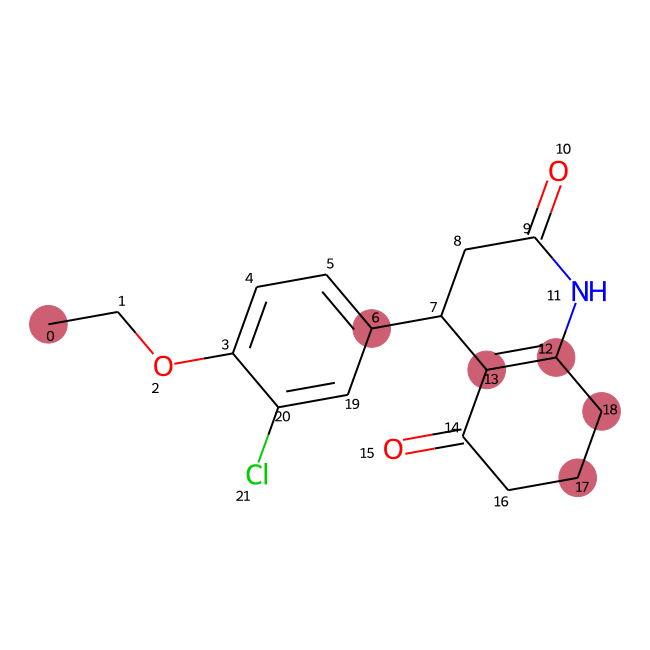

In [21]:
draw(gcn,dataset)

#D#Masks calculate...


D:\anaconda\envs\rdk\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\anaconda\envs\rdk\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


#D#Loss:6.352316379547119
#D#Loss:3.1024627685546875
#D#Loss:1.733199119567871
#D#Loss:1.1389411687850952
#D#Loss:0.8244777917861938
#D#Loss:0.6304936408996582
#D#Loss:0.5014409422874451
#D#Loss:0.41178447008132935
#D#Loss:0.3472026586532593
#D#Loss:0.29898592829704285
#D#Loss:0.26211559772491455
#D#Loss:0.2332385927438736
#D#Loss:0.2100832313299179
#D#Loss:0.19112591445446014
#D#Loss:0.17539025843143463
#D#Loss:0.16216084361076355
#D#Loss:0.15088489651679993
#D#Loss:0.14115212857723236
#D#Loss:0.1326667070388794
#D#Loss:0.12521116435527802
#D#Loss:0.11863303184509277
#D#Loss:0.11269725114107132
#D#Loss:0.10725569725036621
#D#Loss:0.10229408740997314
#D#Loss:0.09771618247032166
#D#Loss:0.09344877302646637
#D#Loss:0.08952800184488297
#D#Loss:0.08587675541639328
#D#Loss:0.08244741708040237
#D#Loss:0.07927097380161285
#D#Loss:0.07634828984737396
#D#Loss:0.07364688068628311
#D#Loss:0.07114916294813156
#D#Loss:0.06884365528821945
#D#Loss:0.06670668721199036
#D#Loss:0.06470875442028046
#D#Lo

D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


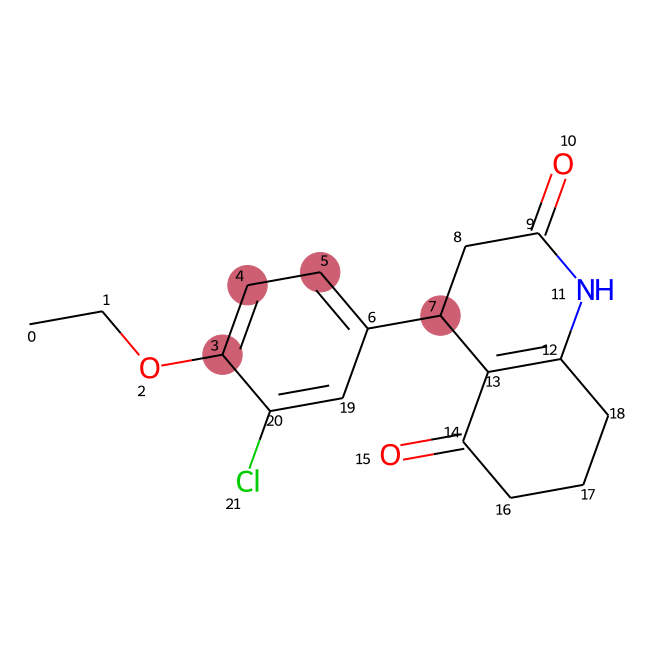

In [37]:
draw(gat,dataset)

#D#Masks calculate...
#D#Loss:6.478936195373535
#D#Loss:3.9401028156280518
#D#Loss:2.807655096054077
#D#Loss:2.3106610774993896
#D#Loss:2.0689547061920166
#D#Loss:1.9296094179153442
#D#Loss:1.8397420644760132
#D#Loss:1.7770085334777832
#D#Loss:1.730997920036316
#D#Loss:1.6960915327072144
#D#Loss:1.6687190532684326
#D#Loss:1.6467657089233398
#D#Loss:1.628843069076538
#D#Loss:1.613983154296875
#D#Loss:1.6014803647994995
#D#Loss:1.5908291339874268
#D#Loss:1.5816580057144165
#D#Loss:1.5736818313598633
#D#Loss:1.5666844844818115
#D#Loss:1.560492753982544
#D#Loss:1.5549757480621338
#D#Loss:1.5500283241271973
#D#Loss:1.545579433441162
#D#Loss:1.5415372848510742
#D#Loss:1.5378726720809937
#D#Loss:1.5345364809036255
#D#Loss:1.531492829322815
#D#Loss:1.5287089347839355
#D#Loss:1.5261584520339966
#D#Loss:1.5238134860992432
#D#Loss:1.5216566324234009
#D#Loss:1.5196661949157715
#D#Loss:1.5178265571594238
#D#Loss:1.5161241292953491
#D#Loss:1.5145405530929565
#D#Loss:1.5130692720413208
#D#Loss:1.5116

D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


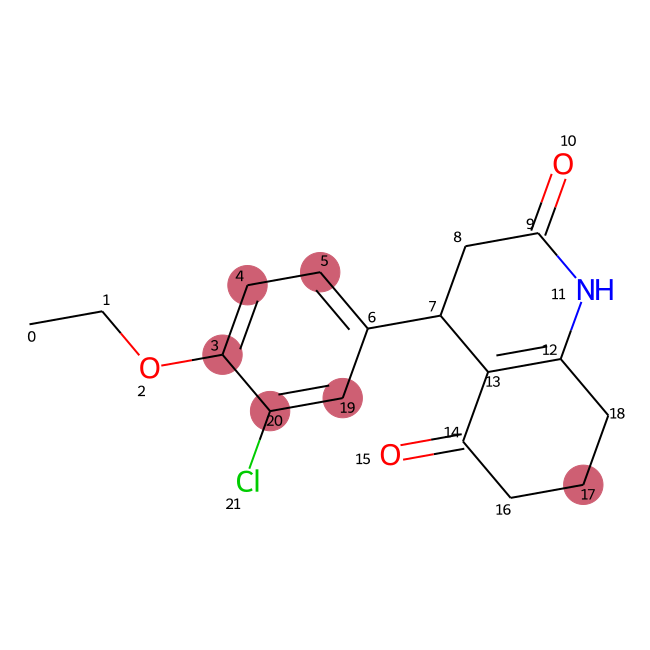

In [38]:
draw(graphsage,dataset)

## PGM-Explainer 

In [15]:
import utils.pgm_explainer_graph as pe

use CPU


In [16]:
def draw(model,datasets):
    model.eval()
    smiles, bg, label, masks = dataset[0]
    n_feats = bg.ndata['hv']
    pred = model.forward(bg, n_feats)
    pred_threshold = 0.05
    e = pe.Graph_Explainer(model, bg,
                           perturb_feature_list=[0],
                           perturb_mode="max",
                           perturb_indicator="diff")
    pgm_nodes, p_values, candidates, num_nodes = e.explain(num_samples=500, percentage=10,
                                                           top_node=50, p_threshold=0.05,
                                                           pred_threshold=pred_threshold)
    atoms = np.arange(num_nodes).tolist()
    important_nodes = []
    for i in pgm_nodes:
        if p_values[i] > 0.05:
            important_nodes.append(i)
    nodes = []
    for n in atoms:
        if n in important_nodes:
            nodes.append(1)
        else:
            nodes.append(0)
    m = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(650,650)
    drawer.SetFontSize(1200)
    op = drawer.drawOptions().addAtomIndices=True
    mol = rdMolDraw2D.PrepareMolForDrawing(m)
    c=nodes
    important_index = []
    for i, value in enumerate(c):
        if value == 1:
            important_index.append(i)
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(206,95,115)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
    atom_cols={}
    for bd in important_index:
        atom_cols[bd] = colors[i%9]
    drawer.DrawMolecule(m,highlightAtoms= important_index,highlightBonds=None,highlightAtomColors=atom_cols,
                        highlightAtomRadii={i: .4 for i in important_index}
                               )
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))

D:\Intepreta\ChemXGNN\utils\pgm_explainer_graph.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float)
D:\anaconda\envs\rdk\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


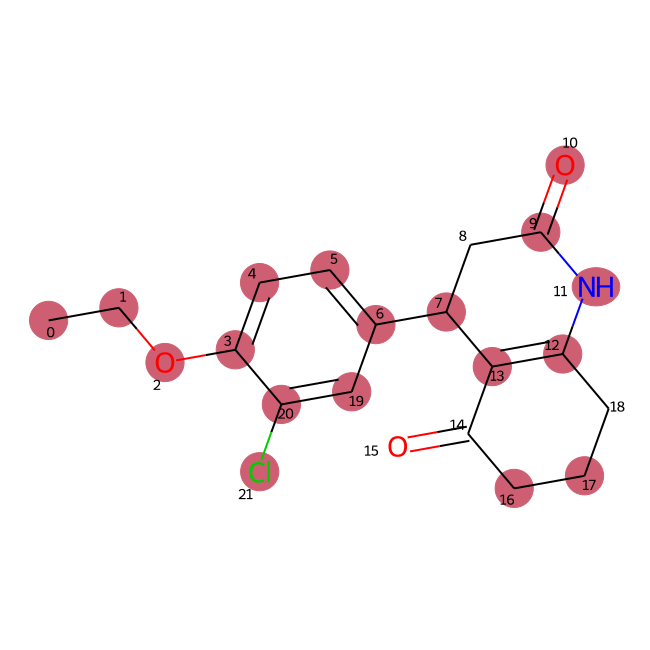

In [17]:
draw(gcn,dataset)

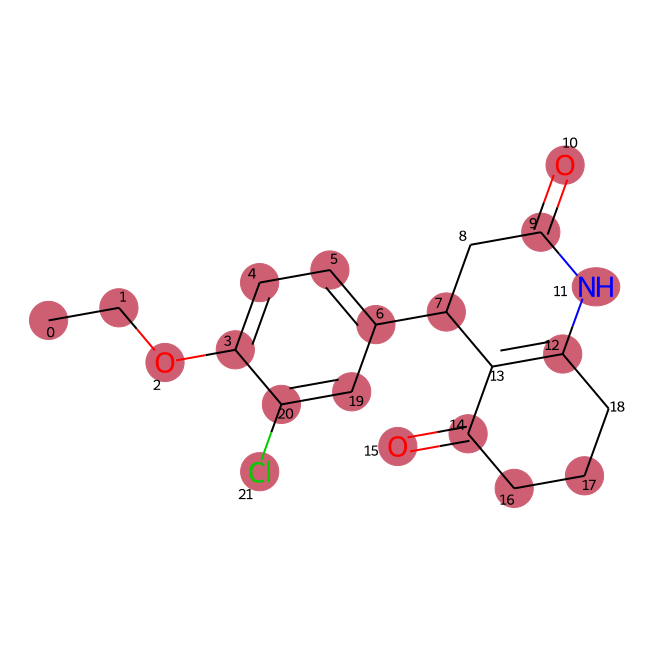

In [18]:
draw(gat,dataset)

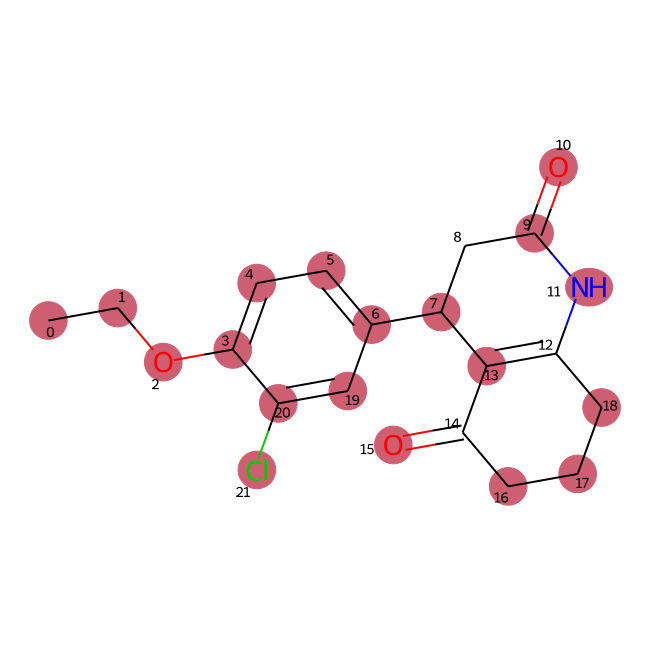

In [19]:
draw(graphsage,dataset)

## SubgraphX 

In [10]:
from utils.mcts import MCTS, reward_func
from utils.configures_shap import mcts_args, reward_args
from utils.shapley import GnnNets_GC2value_func
from scipy.sparse import coo_matrix
def find_closest_node_result(results, max_nodes):
    results = sorted(results, key=lambda x: x.P, reverse=True)
    results = sorted(results, key=lambda x: len(x.coalition))
    result_node = results[0]
    for result_idx in range(len(results)):
        x = results[result_idx]
        if len(x.coalition) <= max_nodes and x.P > result_node.P:
            result_node = x
    return result_node

use CPU


In [11]:
def draw(model,datasets):
    model.eval()
    smiles, bg, label, masks = dataset[0]
    n_feats = bg.ndata['hv']
    pred = model.forward(bg, n_feats)
    value_func = GnnNets_GC2value_func(model)
    mol = Chem.MolFromSmiles(smiles[0])
    adj_arr = Chem.GetAdjacencyMatrix(mol)
    coo_A = coo_matrix(adj_arr)
    b = [coo_A.row.tolist(), coo_A.col.tolist()]
    edges_index = torch.tensor(b)
    payoff_func = reward_func(reward_args, value_func)
    mcts_state_map = MCTS(dataset[0], edges_index,
                          score_func=payoff_func,
                          n_rollout=mcts_args.rollout,
                          min_atoms=mcts_args.min_atoms,
                          c_puct=mcts_args.c_puct,
                          expand_atoms=mcts_args.expand_atoms
                          )
    results = mcts_state_map.mcts(verbose=True)
    graph_node_x = find_closest_node_result(results, max_nodes=50)
    masked_node_list = [node for node in list(range(graph_node_x.ori_graph.ndata['hv'].shape[0]))
                        if node not in graph_node_x.coalition]
    atoms = np.arange(n_feats.shape[0]).tolist()
    nodes = []
    for n in atoms:
        if n in masked_node_list:
            nodes.append(0)
        else:
            nodes.append(1)
    m = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(650,650)
    drawer.SetFontSize(1200)
    op = drawer.drawOptions().addAtomIndices=True
    mol = rdMolDraw2D.PrepareMolForDrawing(m)
    c=nodes
    important_index = []
    for i, value in enumerate(c):
        if value == 1:
            important_index.append(i)
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(206,95,115)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
    atom_cols={}
    for bd in important_index:
        atom_cols[bd] = colors[i%9]
    drawer.DrawMolecule(m,highlightAtoms= important_index,highlightBonds=None,highlightAtomColors=atom_cols,
                        highlightAtomRadii={i: .4 for i in important_index}
                               )
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))

The nodes in graph is 22


D:\anaconda\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


At the 0 rollout, 181 states that have been explored.
At the 1 rollout, 317 states that have been explored.
At the 2 rollout, 337 states that have been explored.
At the 3 rollout, 342 states that have been explored.
At the 4 rollout, 342 states that have been explored.


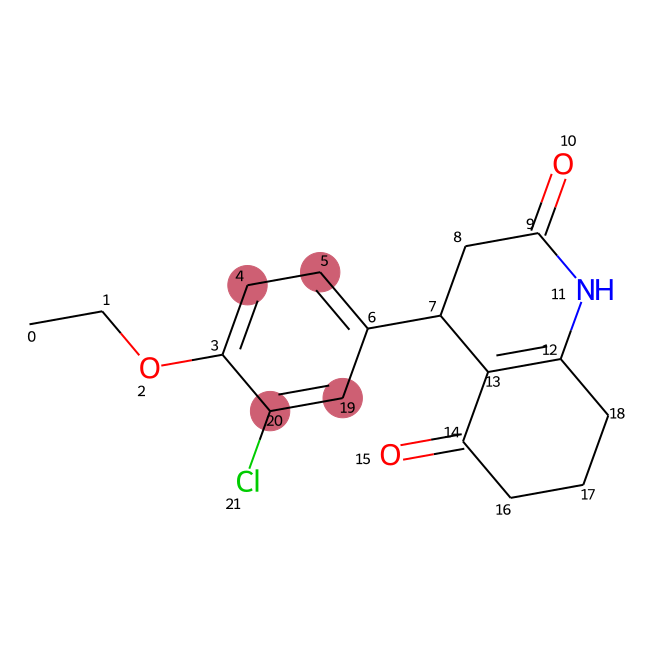

In [12]:
draw(gcn,dataset)

The nodes in graph is 22
At the 0 rollout, 181 states that have been explored.
At the 1 rollout, 317 states that have been explored.
At the 2 rollout, 430 states that have been explored.
At the 3 rollout, 578 states that have been explored.
At the 4 rollout, 702 states that have been explored.


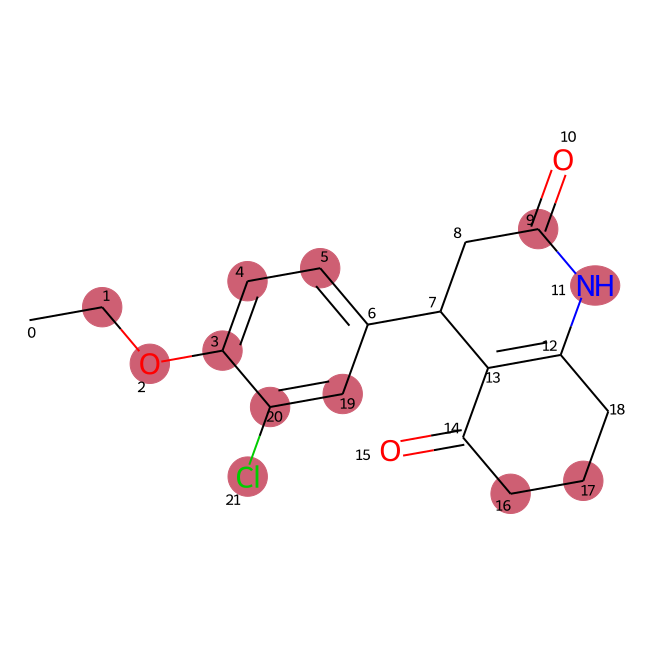

In [17]:
draw(graphsage,dataset)

The nodes in graph is 22
At the 0 rollout, 181 states that have been explored.
At the 1 rollout, 341 states that have been explored.
At the 2 rollout, 449 states that have been explored.
At the 3 rollout, 563 states that have been explored.
At the 4 rollout, 675 states that have been explored.


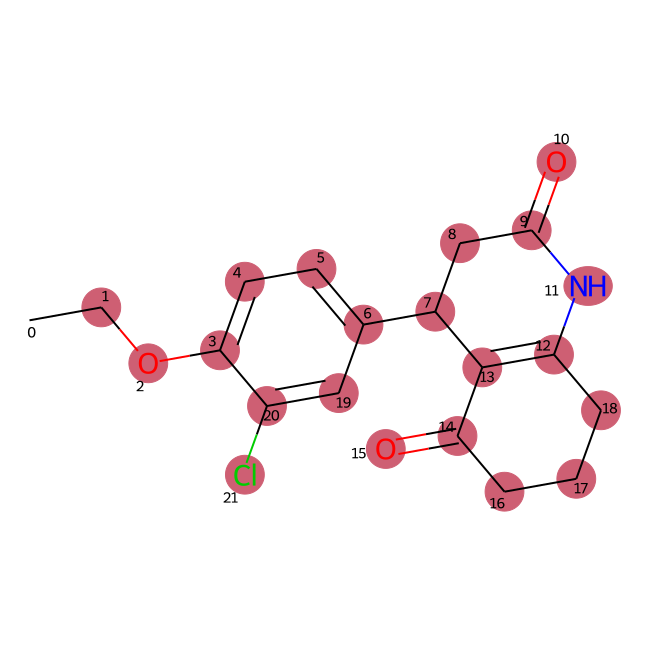

In [13]:
draw(gat,dataset)